# Intelligent Agents: Reflex-Based Agents for the Vacuum-cleaner World

Student Name: Cameron Ervin

## Instructions

Total Points: Undergrads 100 / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a PDF file.

## Introduction

In this assignment you will implement a simulator environment for an automatic vacuum cleaner robot, a set of different reflex-based agent programs, and perform a comparison study for cleaning a single room. Focus on the __cleaning phase__ which starts when the robot is activated and ends when the last dirty square in the room has been cleaned. Someone else will take care of the agent program needed to navigate back to the charging station after the room is clean.

## PEAS description of the cleaning phase

__Performance Measure:__ Each action costs 1 energy unit. The performance is measured as the sum of the energy units used to clean the whole room.

__Environment:__ A room with $n \times n$ squares where $n = 5$. Dirt is randomly placed on each square with probability $p = 0.2$. For simplicity, you can assume that the agent knows the size and the layout of the room (i.e., it knows $n$). To start, the agent is placed on a random square.

__Actuators:__ The agent can clean the current square (action `suck`) or move to an adjacent square by going `north`, `east`, `south`, or `west`.

__Sensors:__ Four bumper sensors, one for north, east, south, and west; a dirt sensor reporting dirt in the current square.  


## The agent program for a simple randomized agent

The agent program is a function that gets sensor information (the current percepts) as the arguments. The arguments are:

* A dictionary with boolean entries for the for bumper sensors `north`, `east`, `west`, `south`. E.g., if the agent is on the north-west corner, `bumpers` will be `{"north" : True, "east" : False, "south" : False, "west" : True}`.
* The dirt sensor produces a boolean.

The agent returns the chosen action as a string.

Here is an example implementation for the agent program of a simple randomized agent:  

In [103]:
import numpy as np

actions = ["north", "east", "west", "south", "suck"]

def simple_randomized_agent(bumpers, dirty, reset = False):
    return np.random.choice(actions)

In [150]:
# define percepts (current location is NW corner and it is dirty)
bumpers = {"north" : True, "east" : False, "south" : False, "west" : True}
dirty = True

# call agent program function with percepts and it returns an action
simple_randomized_agent(bumpers, dirty)

'west'

__Note:__ This is not a rational intelligent agent. It ignores its sensors and may bump into a wall repeatedly or not clean a dirty square. You will be asked to implement rational agents below.

## Simple environment example

We implement a simple simulation environment that supplies the agent with its percepts.
The simple environment is infinite in size (bumpers are always `False`) and every square is always dirty, even if the agent cleans it. The environment function returns a performance measure which is here the number of cleaned squares (since the room is infinite and all squares are constantly dirty, the agent can never clean the whole room as required in the PEAS description above). The energy budget of the agent is specified as `max_steps`.

In [151]:
def simple_environment(agent, max_steps, verbose = True):
    num_cleaned = 0

    for i in range(max_steps):
        dirty = True
        bumpers = {"north" : False, "south" : False, "west" : False, "east" : False}

        action = agent(bumpers, dirty)
        if (verbose): print("step", i , "- action:", action)

        if (action == "suck"):
            num_cleaned = num_cleaned + 1

    return num_cleaned



Do one simulation run with a simple randomized agent that has enough energy for 20 steps.

In [152]:
simple_environment(simple_randomized_agent, max_steps = 20)

step 0 - action: west
step 1 - action: suck
step 2 - action: south
step 3 - action: north
step 4 - action: north
step 5 - action: east
step 6 - action: south
step 7 - action: north
step 8 - action: south
step 9 - action: west
step 10 - action: suck
step 11 - action: north
step 12 - action: south
step 13 - action: south
step 14 - action: west
step 15 - action: north
step 16 - action: suck
step 17 - action: west
step 18 - action: north
step 19 - action: south


3

# Tasks

## General [10 Points]

1. Make sure that you use the latest version of this notebook. Sync your forked repository and pull the latest revision.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formated professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
4. Document your code. Add a short discussion of how your implementation works and your design choices.


## Task 1: Implement a simulation environment [20 Points]

The simple environment above is not very realistic. Your environment simulator needs to follow the PEAS description from above. It needs to:

* Initialize the environment by storing the state of each square (clean/dirty) and making some dirty. ([Help with random numbers and arrays in Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/random_numbers_and_arrays.ipynb))
* Keep track of the agent's position.
* Call the agent function repeatedly and provide the agent function with the sensor inputs.  
* React to the agent's actions. E.g, by removing dirt from a square or moving the agent around unless there is a wall in the way.
* Keep track of the performance measure. That is, track the agent's actions until all dirty squares are clean and count the number of actions it takes the agent to complete the task.

The easiest implementation for the environment is to hold an 2-dimensional array to represent if squares are clean or dirty and to call the agent function in a loop until all squares are clean or a predefined number of steps have been reached (i.e., the robot runs out of energy).

The simulation environment should be a function like the `simple_environment()` and needs to work with the simple randomized agent program from above. **Use the same environmnt for all your agent implementations in the tasks below.**

*Note on debugging:* Debugging is difficult. Make sure your environment prints enough information when you use `verbose = True`. Also, implementing a function that the environment can use to displays the room with dirt and the current position of the robot at every step is very useful.  

In [8]:
import numpy as np
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

In [23]:
def show_room(room, pos, fontsize = 24):
    """display room and robot

    Parameters
    ----------
    room : bool 2d array
        Dirt locations in the room.
    pos : list of 2 int values
        x and y location of the robot.
    fint_size : int
        size of the robot symbol.
    """

    cmap = colors.ListedColormap(['white', 'gray'])

    room = np.copy(room)
    room = room.astype(np.int64)

    fig, ax = plt.subplots()
    ax.imshow(room, cmap = cmap, norm = colors.BoundaryNorm(list(range(cmap.N+1)), cmap.N))

    plt.text(pos[1], pos[0], u"\u2B24", fontsize = fontsize,
                 horizontalalignment = 'center', verticalalignment = 'center')

    plt.show()

### Environment Implementation:

In [68]:
def environment(agent, n = 5, p = .2, verbose = False):

  # max steps by area plus diagonal
  # multiplied by 1.5 to give buffer between lower performers
  max_steps = round(1.5 * (n*n + (2 * math.sqrt(n**2 + n**2))))

  # environment with dirty sqaures
  env_arr = np.random.choice([True, False], (n,n), p=[p, 1-p])
  num_dirty = np.sum(env_arr)

  # random starting position in environment
  pos = [random.randrange(n),random.randrange(n)]

  if verbose:
      print(f"room with {num_dirty} dirty squares:\n{env_arr}")
      print(f"Staring position: {pos}")
      print("\nstart simulation")

  for step in range(1, max_steps+1):

    # prepare percepts
    bumpers = {
      "north": pos[0] == 0,
      "south": pos[0] == n-1,
      "west" : pos[1] == 0,
      "east" : pos[1] == n-1
              }
    dirty = env_arr[pos[0], pos[1]]

    if verbose:
      print('-' * 50, "\n")
      print(f"step: {step}")
      show_room(env_arr, pos)
      print(f"current position: {pos}")
      print(f"percepts: bumpers={bumpers}, dirty={dirty}")

    # call agent program
    action = agent(bumpers, dirty)
    if verbose:
      print("agent's action: ", action)

    # apply action to the environment
    if action == "north" and pos[0]>0:     pos[0] = pos[0]-1
    if action == "south" and pos[0]<(n-1): pos[0] = pos[0]+1
    if action == "west"  and pos[1]>0:     pos[1] = pos[1]-1
    if action == "east"  and pos[1]<(n-1): pos[1] = pos[1]+1
    if action == "suck": env_arr[pos[0], pos[1]] = False

    # check for goal state and return performance measure
    num_dirty = np.sum(env_arr)
    if verbose:
      print(f"dirty squares left: {num_dirty}")

    if num_dirty < 1:
      action = agent(bumpers, dirty, reset = True)
      break


  return step

  # call reset function if reach max steps (mainly for model-based)
  if step == max_steps:
    action = agent(bumpers, dirty, reset = True)

## Task 2:  Implement a simple reflex agent [10 Points]

The simple reflex agent randomly walks around but reacts to the bumper sensor by not bumping into the wall and to dirt with sucking. Implement the agent program as a function.

_Note:_ Agents cannot directly use variable in the environment. They only gets the percepts as the arguments to the agent function.

In [ ]:
def simple_reflex_agent(bumpers, dirty, reset = False):
    if(dirty) : return("suck")

    directions = [direction for (direction, blocked) in bumpers.items() if not blocked]
    return random.choice(directions)

environment(simple_reflex_agent)

## Task 3: Implement a model-based reflex agent [20 Points]

Model-based agents use a state to keep track of what they have done and perceived so far. Your agent needs to find out where it is located and then keep track of its current location. You also need a set of rules based on the state and the percepts to make sure that the agent will clean the whole room. For example, the agent can move to a corner to determine its location and then it can navigate through the whole room and clean dirty squares.

Describe how you define the __agent state__ and how your agent works before implementing it. ([Help with implementing state information on Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb))

### Agent Description and Implementation:

The model based reflex agent first moves to the northwest corner of the room by moving until the percepts indicate it has reached the north wall and then by moving until it has reached the west wall.

The agent keeps track of its position using the internal state variable pos for position. Once the NW corner is reached, the agent declares this location as position [0,0]. From there, the agent snakes through the room updating two lists - frontier and visited. Frontier is the list of locations in the agents solution path to clean the room, and visited is the list of all squares visited.

The agent checks the squares around using the bumpers percept to see if it can advance to the next square. It also checks the visited list to see if it has been to that square before. Next, it adds the square to the frontier list and then moves to that square.

If the square it is on returns the dirty percept, the robot cleans the square it is on.

If the agent reaches the max number of steps, or all of the squares have been cleaned, the agent resets its frontier, visited, and position.

In [69]:
class model_based_reflex_agent:
  def __init__(self):
  # these variables form the agent's state
    self.frontier = list()
    self.visited = list()
    self.pos = [0,0]

  # reset function used for simulation
  def reset(self):
    self.frontier = list()
    self.visited = list()
    self.pos = [0,0]

  # main act function
  def act(self, bumpers, dirty, reset = False):

    # call reset function if reset percept is true
    if reset == True:
     self.reset()

    nav = { "north": [-1,0], "east": [0,1], "south": [1,0], "west": [0,-1] }
    directions = ["north", "east", "south", "west"]

    current_pos = self.pos
    self.visited.append(tuple(current_pos))
    if tuple(current_pos) in self.frontier:
      self.frontier.remove(tuple(current_pos))

    '''
    print("Agent state:")
    print(f"  pos: {self.pos}")
    print(f"  visited: {self.visited}")
    print(f"  old frontier: {self.frontier}")
    '''

    # find corner of room
    if len(self.frontier) == 0:
    #  print("Relocating to the NW corner of the room")
      while bumpers['north'] != True:
        while bumpers['west'] != True:
          return("north")
        return("west")

    if dirty:
      return("suck")

    # expand frontier (note that I do not check if a position is already in the frontier. I deal with that above.)
    for direction in directions:
      new_pos = tuple(np.add(current_pos, nav[direction]))
      if not bumpers[direction] and not new_pos in self.visited:
          self.frontier.append(new_pos)

    # print(f"  expanded frontier: {self.frontier}")

    # go to the square added to the frontier last (LIFO). **This square is adjacent if there are not obstacles.**
    goto_pos = self.frontier[-1]
    self.pos = goto_pos

    # print(f"  I want to go to: {goto_pos}")

    if goto_pos[0] < current_pos[0]: return("north")
    if goto_pos[0] > current_pos[0]: return("south")
    if goto_pos[1] > current_pos[1]: return("east")
    if goto_pos[1] < current_pos[1]: return("west")

    # this should not happen!
    return("error")

In [70]:
my_model_based_reflex_agent = model_based_reflex_agent()
environment(my_model_based_reflex_agent.act)

17

## Task 4: Simulation study [30 Points]

Compare the performance (the performance measure is defined in the PEAS description above) of the agents using  environments of different size. E.g., $5 \times 5$, $10 \times 10$ and
$100 \times 100$. Use 100 random runs for each. Present the results using tables and graphs. Discuss the differences between the agents.
([Help with charts and tables in Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/charts_and_tables.ipynb))

In [170]:
def sim_runs(n, agent, N = 100):
  return [ environment(agent, n = n, verbose = False) for _ in range(N) ]

np.random.seed(2023)

In [171]:
# simulation runs for each model type
RA_5 = sim_runs(5, simple_randomized_agent)
# mean number of steps
m_RA_5 = np.mean(RA_5)

SRA_5 = sim_runs(5, simple_reflex_agent)
m_SRA_5 = np.mean(SRA_5)

MBRA_5 = sim_runs(5, my_model_based_reflex_agent.act)
m_MBRA_5 = np.mean(MBRA_5)

RA_10 = sim_runs(10, simple_randomized_agent)
m_RA_10 = np.mean(RA_10)

SRA_10 = sim_runs(10, simple_reflex_agent)
m_SRA_10 = np.mean(SRA_10)

MBRA_10 = sim_runs(10, my_model_based_reflex_agent.act)
m_MBRA_10 = np.mean(MBRA_10)

RA_100 = sim_runs(100, simple_randomized_agent)
m_RA_100 = np.mean(RA_100)

SRA_100 = sim_runs(100, simple_reflex_agent)
m_SRA_100 = np.mean(SRA_100)

MBRA_100 = sim_runs(100, my_model_based_reflex_agent.act)
m_MBRA_100 = np.mean(MBRA_100)

Fill out the following table with the average performance measure for 100 random runs (you may also create this table with code):





In [172]:
# create chart
sim_performance = pd.DataFrame({"Randomized Agent":[m_RA_5, m_RA_10, m_RA_100],
                   "Simple Reflex Agent":[m_SRA_5, m_SRA_10, m_SRA_100],
                   "Model-based Reflex Agent":[m_MBRA_5, m_MBRA_10, m_MBRA_100]})
sim_performance.index = ("5x5", "10x10", "100x100")
sim_performance

,Randomized Agent,Simple Reflex Agent,Model-based Reflex Agent
5x5,59.0,52.55,32.04
10x10,192.0,192.00,128.64
100x100,15424.0,15424.00,12045.01


Add charts to compare the performance of the different agents.

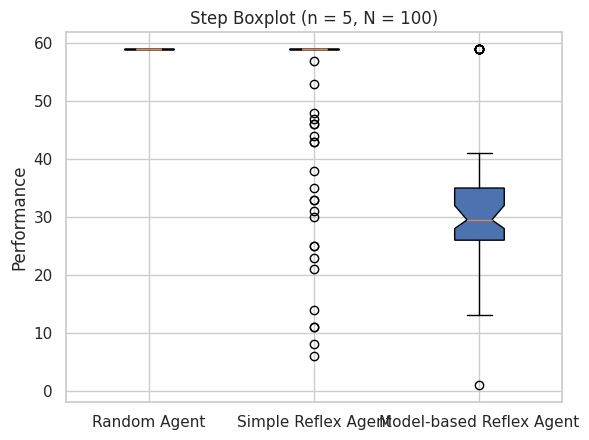

In [203]:
# Boxplots
bplot = plt.boxplot(([RA_5, SRA_5, MBRA_5]),
                     notch = True,                 # show 95% confidence intervals around the median
                     bootstrap = 1000,             # used to calculate the notches
                     vert = True,                  # vertical box alignment
                     patch_artist = True,          # fill with color
                     labels = ["Random Agent", "Simple Reflex Agent", "Model-based Reflex Agent"])  # will be used to label x-ticks
plt.ylabel("Performance")
plt.title("Step Boxplot (n = 5, N = 100)")
plt.show()

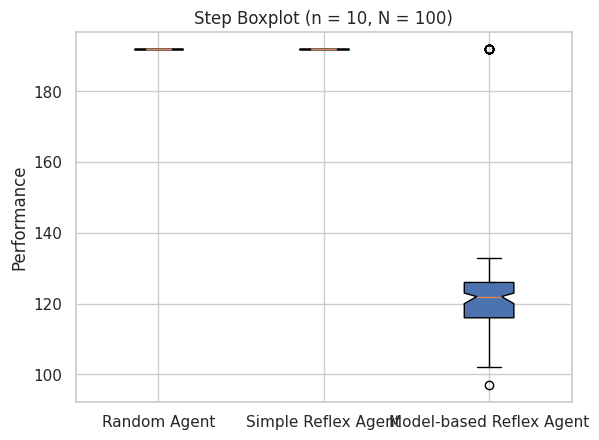

In [204]:
bplot = plt.boxplot(([RA_10, SRA_10, MBRA_10]),
                     notch = True,                 # show 95% confidence intervals around the median
                     bootstrap = 1000,             # used to calculate the notches
                     vert = True,                  # vertical box alignment
                     patch_artist = True,          # fill with color
                     labels = ["Random Agent", "Simple Reflex Agent", "Model-based Reflex Agent"])  # will be used to label x-ticks
plt.ylabel("Performance")
plt.title("Step Boxplot (n = 10, N = 100)")
plt.show()

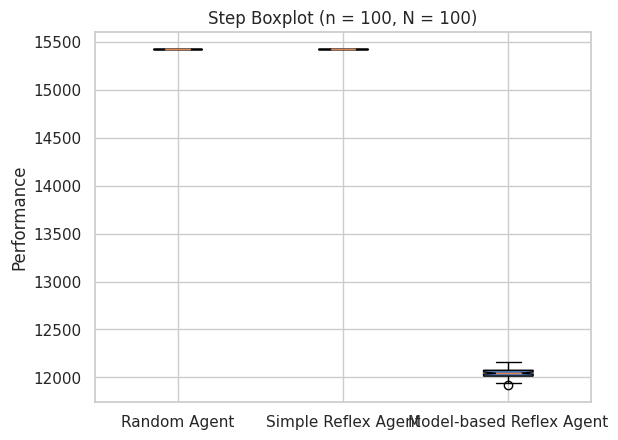

In [205]:
bplot = plt.boxplot(([RA_100, SRA_100, MBRA_100]),
                     notch = True,                 # show 95% confidence intervals around the median
                     bootstrap = 1000,             # used to calculate the notches
                     vert = True,                  # vertical box alignment
                     patch_artist = True,          # fill with color
                     labels = ["Random Agent", "Simple Reflex Agent", "Model-based Reflex Agent"])  # will be used to label x-ticks
plt.ylabel("Performance")
plt.title("Step Boxplot (n = 100, N = 100)")
plt.show()

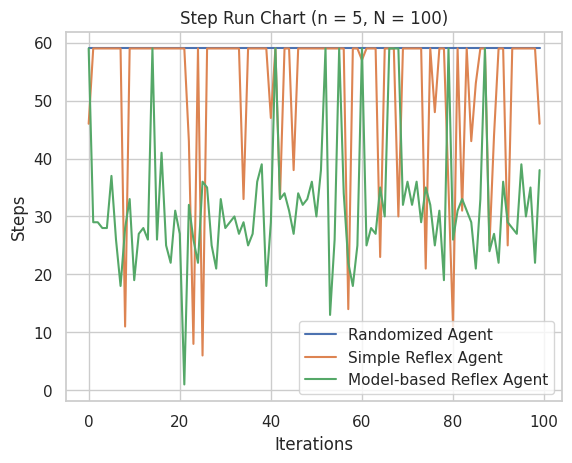

In [178]:
# Line charts
sns.set(style="whitegrid")
N = 100
x = range(N)

plt.plot(x, RA_5, label = "Randomized Agent")
plt.plot(x, SRA_5, label = "Simple Reflex Agent")
plt.plot(x, MBRA_5, label = "Model-based Reflex Agent")

plt.title("Step Run Chart (n = 5, N = 100)")
plt.xlabel("Iterations")
plt.ylabel("Steps")
plt.legend()
plt.show()

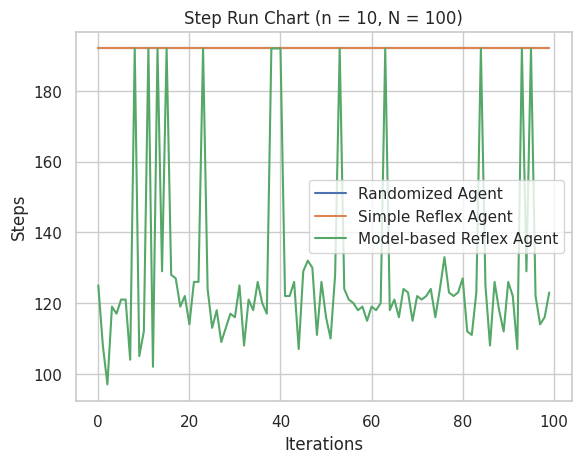

In [179]:
plt.plot(x, RA_10, label = "Randomized Agent")
plt.plot(x, SRA_10, label = "Simple Reflex Agent")
plt.plot(x, MBRA_10, label = "Model-based Reflex Agent")

plt.title("Step Run Chart (n = 10, N = 100)")
plt.xlabel("Iterations")
plt.ylabel("Steps")
plt.legend()
plt.show()

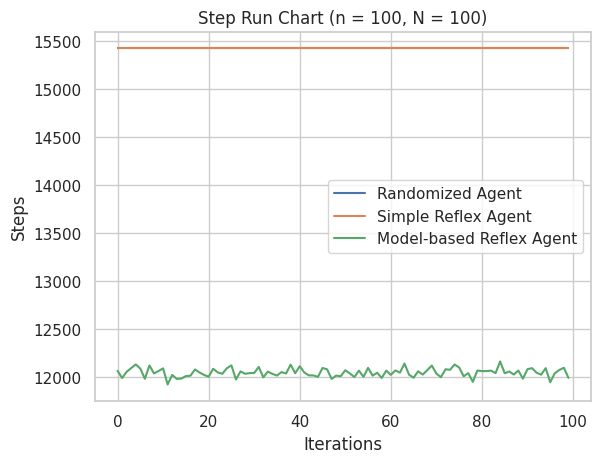

In [180]:
plt.plot(x, RA_100, label = "Randomized Agent")
plt.plot(x, SRA_100, label = "Simple Reflex Agent")
plt.plot(x, MBRA_100, label = "Model-based Reflex Agent")

plt.title("Step Run Chart (n = 100, N = 100)")
plt.xlabel("Iterations")
plt.ylabel("Steps")
plt.legend()
plt.show()

### Chart Interpretation:
As the size of the room increases, the disparity between the performance of the different models also increases. For n = 5, the random agent has the worst performance followed by the simple reflex agent and then the model-based agent. As the size of the room increases, this difference becomes larger and larger. At size n = 10 and size n = 100, the random agent and simple reflex agents reach the max number of steps for every run. Meanwhile, the model-based agent takes an average of 128.64 and 12045.01 respectively.

## Task 5: Robustness of the agent implementations [10 Points]

Describe how **your agent implementations** will perform

* if it is put into a rectangular room with unknown size,

  RA - The random agent would have the same performance as a square room since it acts entirely randomly.

  SRA - Depending on the dimensions of the room, the simple reflex agent would have either better or worse performance. As the rectangle gets more narrow, the agent would have better performance if it can run longways down the rectangle. If the rectangle was wider, it would probably have about the same performance.

  MBRA - The model-based agent would have the same performance as before since it finds the corner of the room and then operates.
* if the cleaning area can have an iregular shape (e.g., a hallway connecting two rooms), or
  RA - The random agent would have a worse performance. The performance of the agent would depend on the random chance that it chooses to go down the hallway. If not, it would only clean the room it is initially in.

  SRA - The simple reflex agent would also perform worse compared to the square or rectangular room. Since the agent has no sense of state or where it has been, it would repeatedly sweep the initial room unless it can go down the hallway by chance.
  
  MBRA - The model-based agent would still perform well since it keeps a list of visited squares as well as the frontier. Since the agent can remember where it has been, the agent would still perform well.
* if the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors).

  RA - The random agent would have slightly worse performance since it does not take into account for any bumpers. Any obstacle in the room would cause the agent to be even less productive since it would run into the obstacles.

  SRA - The simple reflex agent would also have worse performance since it would run into the obstacles and set off the bumper percepts. This would cause the agent to move at random away from the obstacle rather than moving across the room and potentially cleaning.
  
  MBRA - The model-based agent would have the same performance since it remebers where it is at, where it has visited, and what the frontier is. It would move near the obstacles and clean around them.

## Graduate student advanced task: Obstacles [10 Points]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 Bonus Points].

1. Change your simulation environment tor run experiments for the following problem: Add random obstacle squares that also trigger the bumper sensor. The agent does not know where the obstacles are. Observe how this changes the performance of the three implementations.

In [99]:
# implement the obstacle

def environment_obj(agent, n = 5, p = .2, verbose = False):

  # max steps by area plus diagonal
  max_steps = round(n*n + (2 * math.sqrt(n**2 + n**2)))

  # environment with dirty sqaures
  env_arr = np.random.choice([True, False], (n,n), p=[p, 1-p])
  num_dirty = np.sum(env_arr)

  obj = [random.randrange(n),random.randrange(n)]
  env_arr[obj] = False
  # print(f"object location: {obj}")

  # random starting position in environment
  pos = [random.randrange(n),random.randrange(n)]

  while pos == obj:
    pos = [random.randrange(n),random.randrange(n)]

  if verbose:
      print(f"room with {num_dirty} dirty squares:\n{env_arr}")
      print(f"Staring position: {pos}")
      print("\nstart simulation")

  for step in range(1, max_steps+1):

    # prepare percepts
    bumpers = {
      "north": pos[0] == 0,
      "south": pos[0] == n-1,
      "west" : pos[1] == 0,
      "east" : pos[1] == n-1,
              }
    dirty = env_arr[pos[0], pos[1]]

    if verbose:
      print('-' * 50, "\n")
      print(f"step: {step}")
      show_room(env_arr, pos)
      print(f"current position: {pos}")
      print(f"percepts: bumpers={bumpers}, dirty={dirty}")

    # call agent program
    action = agent(bumpers, dirty)
    # print(f"action: {action}")
    if verbose:
      print("agent's action: ", action)

    # apply action to the environment
    # changed second argument of environment to reflect location of object
    if action == "north" and pos[0]>0 and pos != obj:     pos[0] = pos[0]-1
    if action == "south" and pos[0]<(n-1) and pos != obj: pos[0] = pos[0]+1
    if action == "west"  and pos[1]>0 and pos != obj :     pos[1] = pos[1]-1
    if action == "east"  and pos[1]<(n-1) and pos != obj: pos[1] = pos[1]+1
    if action == "suck": env_arr[pos[0], pos[1]] = False

    # check for goal state and return performance measure
    num_dirty = np.sum(env_arr)
    if verbose:
      print(f"dirty squares left: {num_dirty}")

    if num_dirty < 1:
      break
  return step

In [104]:
environment_obj(simple_randomized_agent)

39

In [100]:
environment_obj(simple_reflex_agent)

39

In [101]:
my_model_based_reflex_agent_obj = model_based_reflex_agent()
environment_obj(my_model_based_reflex_agent.act)

30

2. Describe what would need to be done to perform better with obstacles. Add code if you can.

The main addition to the agents in the obstacle environment would be a statement that would avoid the obstacle in the event it was on the path to the Northwest corner of the model-bases agent. All three models avoid the obstacle square. However, the one problem I ran into while testing the new environment was if the obstacle was on the path to the NW corner for the model-based agent. The agent would not behave in a rational way with the obstacle. While the agent is en route to the NW corner, it only takes into account the "north" and "west" percepts. Therefore, I would need to add a statement to handle the path to the NW corner better. This could be implemented with another percept on the way to the NW corner.

The other two agents cannot be optimized further with the obstacle in the environment.

## More advanced implementation tasks

* __Agent for and environment with obstacles:__ Implement an agent for an environment where the agent does not know how large the environment is (we assume it is rectangular), where it starts or where the obstacles are. An option would be to always move to the closest unchecked/uncleaned square (note that this is actualy depth-first search).

* __Utility-based agent:__ Change the environment for a $5 \times 5$ room, so each square has a fixed probability of getting dirty again. For the implementation, we give the environment a 2-dimensional array of probabilities. The utility of a state is defined as the number of currebntly clean squares in the room. Implement a utility-based agent that maximizes the expected utility over one full charge which lasts for 100000 time steps. To do this, the agent needs to learn the probabilities with which different squares get dirty again. This is very tricky!

In [ ]:
# Your ideas/code